In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [9]:
# ===================================
# LOAD DATA / FEATURES(X) / TARGET(Y)
# ===================================
df = pd.read_csv('task_data.csv')

X = df[['Heart width', 'Lung width','CTR - Cardiothoracic Ratio',
        'xx', 'yy', 'xy', 'normalized_diff','Inscribed circle radius',
        'Polygon Area Ratio', 'Heart perimeter','Heart area ', 'Lung area']]

y = df['Cardiomegaly']

In [10]:
# =================================
# TRAIN-TEST SPLIT AND DATA SCALING
# =================================

X = X.replace(',', '.', regex=True).astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [47]:
# ==============
# EVALUATE MODEL
# ==============
def evaluate_model(model, model_name, X_data, y_labels):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fig, (ax_cm, ax_bar) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
    fig.subplots_adjust(bottom=0.25)

    # ================
    # CROSS-VALIDATION
    # ================
    acc_list, precision_list, recall_list, f1_list = [], [], [], []
    all_actual, all_predicted = [], []

    for train_idx, test_idx in kf.split(X_data, y_labels):
        X_train_fold, X_test_fold = X_data[train_idx], X_data[test_idx]
        y_train_fold, y_test_fold = np.array(y_labels)[train_idx], np.array(y_labels)[test_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)

        all_actual.extend(y_test_fold)
        all_predicted.extend(preds)

        acc_list.append(accuracy_score(y_test_fold, preds))
        precision_list.append(precision_score(y_test_fold, preds))
        recall_list.append(recall_score(y_test_fold, preds))
        f1_list.append(f1_score(y_test_fold, preds))

    # ================
    # CONFUSION MATRIX
    # ================
    cm = confusion_matrix(all_actual, all_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Sick"])
    disp.plot(cmap=plt.cm.Blues, ax=ax_cm, colorbar=False)
    ax_cm.set_title(f"{model_name} - Confusion Matrix")
    ax_cm.set_xlabel("Predicted label")
    ax_cm.set_ylabel("True label")

    cm_table = [["Metric", "Count"],
                ["True Healthy (TN)", cm[0,0]],
                ["True Sick (TP)", cm[1,1]],
                ["False Healthy (FN)", cm[1,0]],
                ["False Sick (FP)", cm[0,1]]]
    
    table_cm_ax = ax_cm.table(cellText=cm_table, loc='bottom', cellLoc='center', bbox=[0, -0.4, 1, 0.25])
    table_cm_ax.auto_set_font_size(False)
    table_cm_ax.set_fontsize(11)
    for (r, c), cell in table_cm_ax.get_celld().items():
        if r == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')

    # ==========================
    # PER-FOLD METRICS BAR CHART
    # ==========================
    positions = np.arange(5)
    bar_height = 0.18

    ax_bar.barh(positions - 1.5*bar_height, acc_list, bar_height, label='Accuracy')
    ax_bar.barh(positions - 0.5*bar_height, precision_list, bar_height, label='Precision')
    ax_bar.barh(positions + 0.5*bar_height, recall_list, bar_height, label='Recall')
    ax_bar.barh(positions + 1.5*bar_height, f1_list, bar_height, label='F1-score')

    ax_bar.set_xlabel('Score')
    ax_bar.set_yticks(positions)
    ax_bar.set_yticklabels([f"Fold {i+1}" for i in range(5)])
    ax_bar.set_xlim(0, 1.05)
    ax_bar.set_title("Per-Fold Metrics")
    ax_bar.legend(loc='lower right')

    for i in range(5):
        for j, metric_list in enumerate([acc_list, precision_list, recall_list, f1_list]):
            ax_bar.text(metric_list[i] + 0.01, positions[i] + (j-1.5)*bar_height, f"{metric_list[i]:.2f}", va='center', fontsize=9)

    # ======================
    # PER-FOLD METRICS TABLE
    # ======================
    metrics_table = [[f"Fold {i+1}", f"{acc_list[i]:.2f}", f"{precision_list[i]:.2f}", f"{recall_list[i]:.2f}", f"{f1_list[i]:.2f}"]
                     for i in range(5)]
    metrics_table.append(["Average", f"{np.mean(acc_list):.2f}", f"{np.mean(precision_list):.2f}",
                          f"{np.mean(recall_list):.2f}", f"{np.mean(f1_list):.2f}"])

    columns = ["Fold", "Accuracy", "Precision", "Recall", "F1-score"]
    table_ax = ax_bar.table(cellText=metrics_table, colLabels=columns, loc='bottom', cellLoc='center', bbox=[0, -0.45, 1, 0.3])
    table_ax.auto_set_font_size(False)
    table_ax.set_fontsize(11)
    for (r, c), cell in table_ax.get_celld().items():
        if r == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')

    plt.tight_layout()
    ax_bar.set_ylim(-1, 5)

    model_name_underscore = model_name.replace(" ", "_")
    plt.savefig(f"plot_{model_name_underscore}.png")
    
    plt.show()

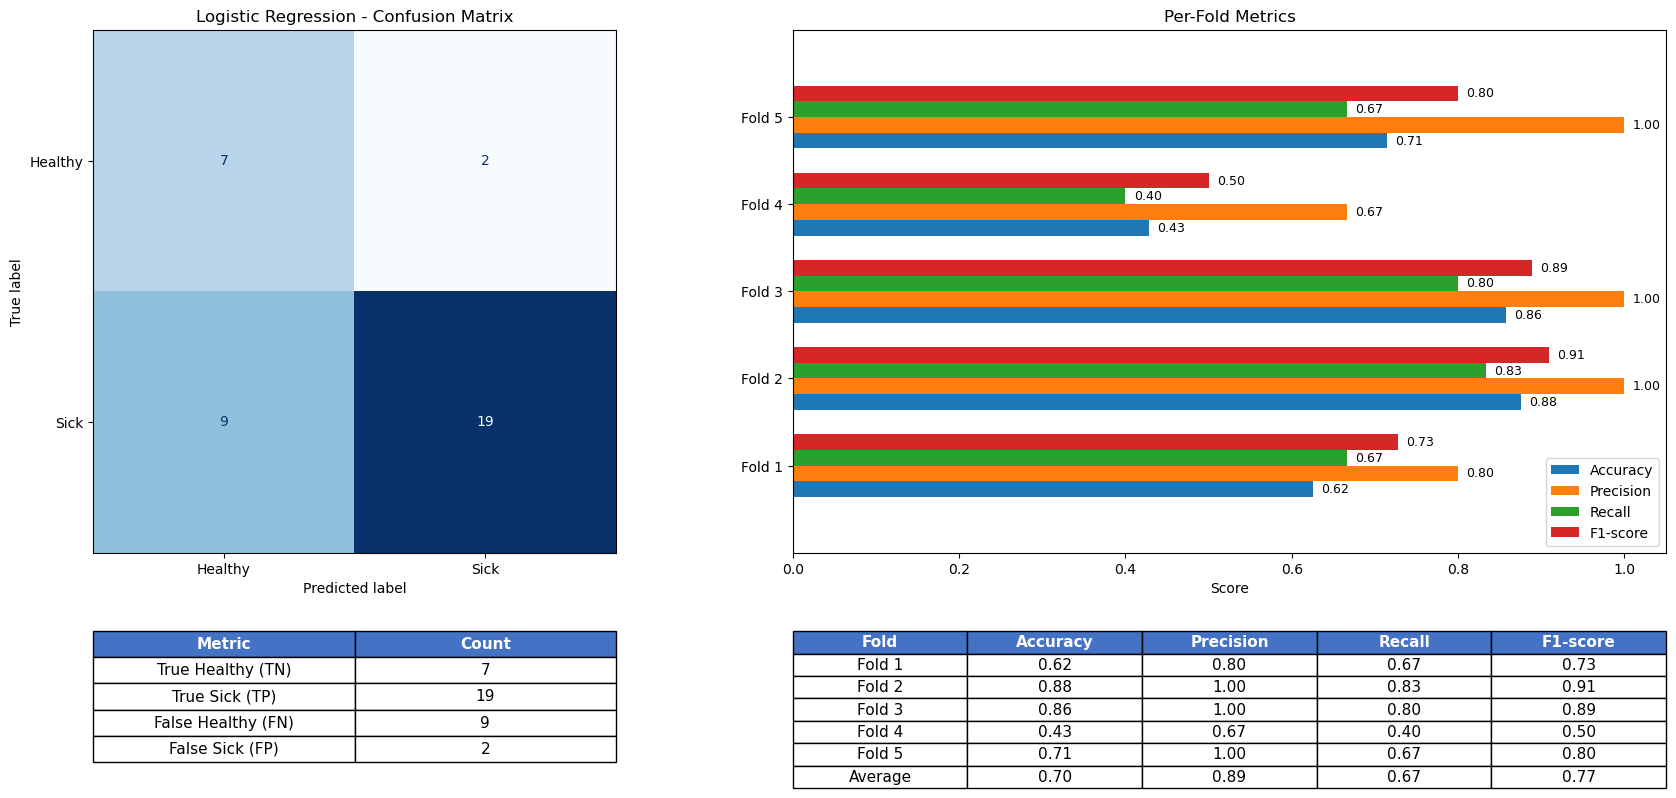

In [48]:
# =================================================
# LOGISTIC REGRESSION INITIALIZATION AND EVALUATION
# =================================================
lr = LogisticRegression(solver='liblinear',
                        penalty='l2',
                        C=1.0,
                        class_weight='balanced',
                        random_state=42)

evaluate_model(lr, "Logistic Regression", X_scaled, y)

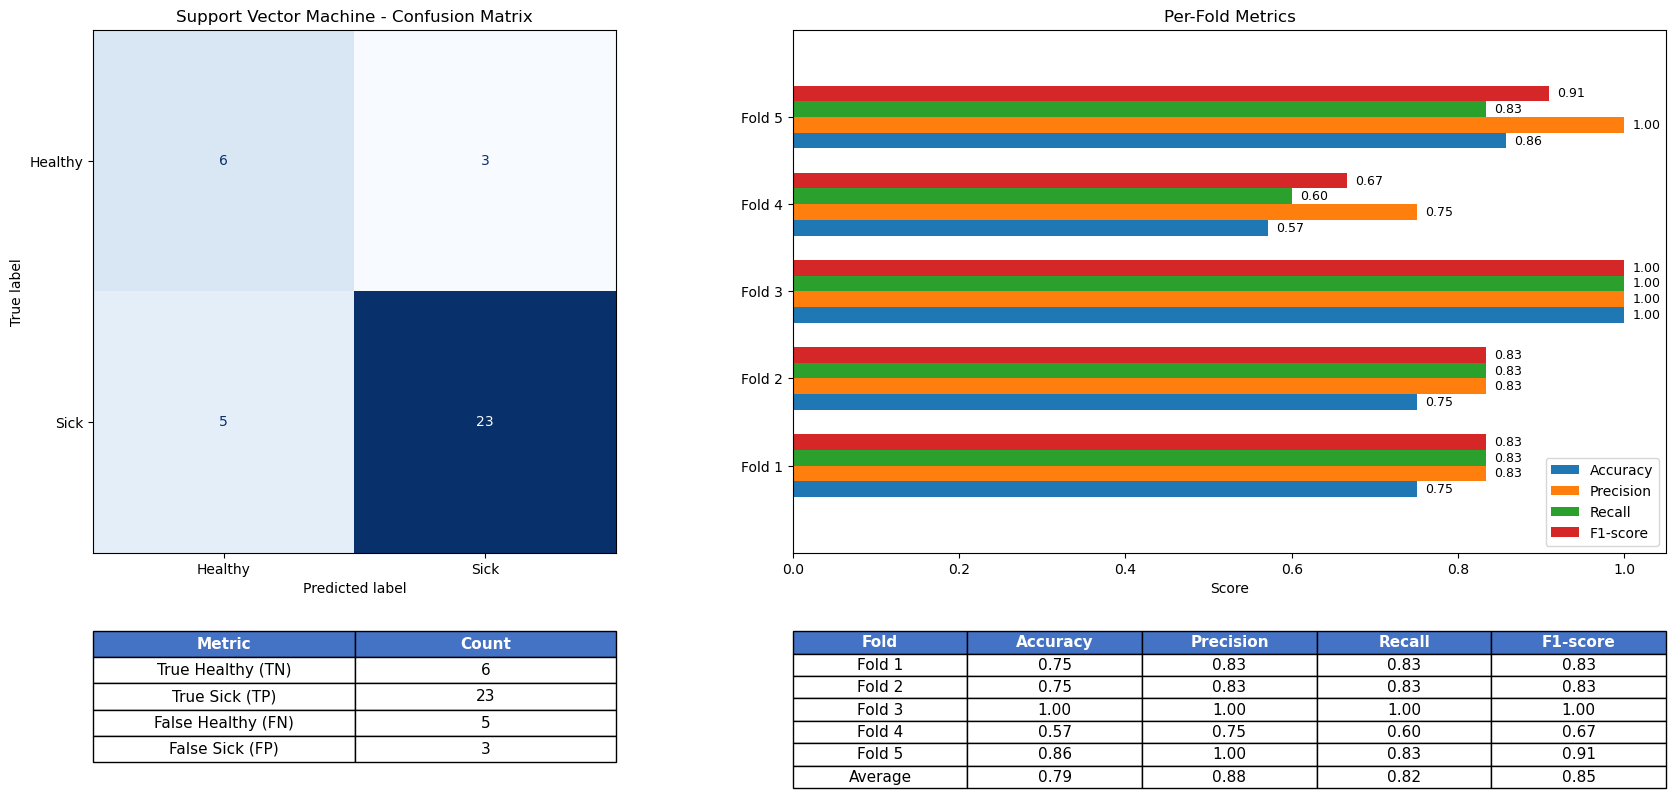

In [49]:
# ====================================================
# SUPPORT VECTOR MACHINE INITIALIZATION AND EVALUATION
# ====================================================
svm = SVC(kernel='rbf',
          class_weight='balanced',
          probability=True,
          random_state=42)

evaluate_model(svm, "Support Vector Machine", X_scaled, y)

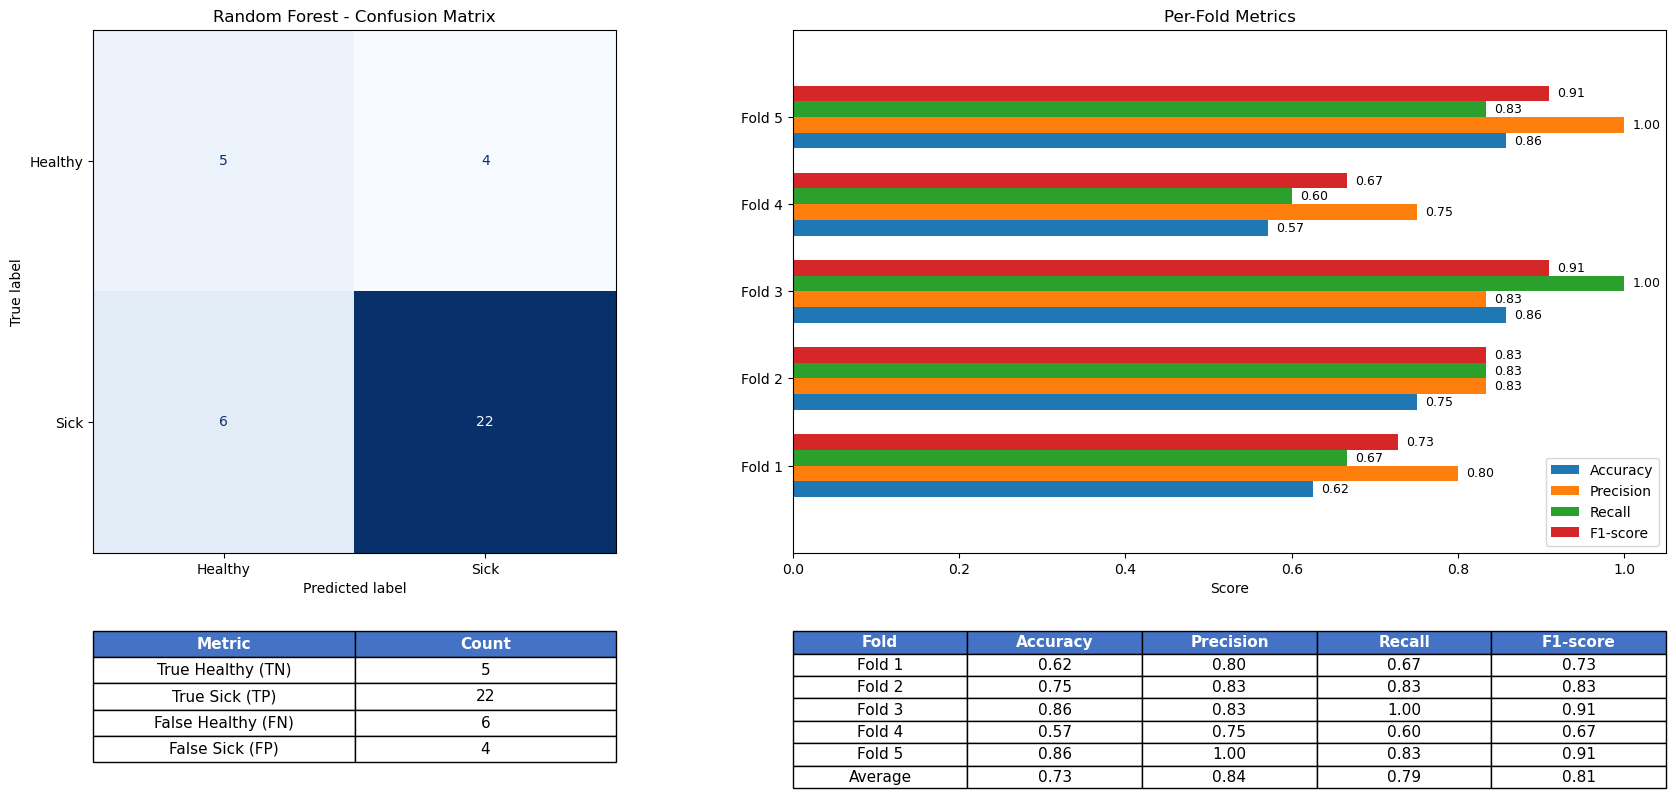

In [50]:
# ===========================================
# RANDOM FOREST INITIALIZATION AND EVALUATION
# ===========================================
rf = RandomForestClassifier(max_depth=6,
                            min_samples_split=6,
                            n_estimators=125,
                            min_samples_leaf = 2,
                            class_weight='balanced',
                            max_features = 'sqrt',
                            random_state=42)

evaluate_model(rf, "Random Forest", X_scaled, y)